In [1]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
import numpy as np
import copy

In [2]:
## TODO: convert date range to datetime column
## TODO: time series prediction for next X days (say next month)

In [3]:
obsidian_flames = pd.read_csv('Obsidian_Flames.csv', index_col = 'Unnamed: 0')
obsidian_flames

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,['Holofoil Market Price: '],7/18 to 7/20,$0.00
1,Absol ex - 135/197,['Holofoil Market Price: '],7/21 to 7/23,$0.00
2,Absol ex - 135/197,['Holofoil Market Price: '],7/24 to 7/26,$0.00
3,Absol ex - 135/197,['Holofoil Market Price: '],7/27 to 7/29,$0.00
4,Absol ex - 135/197,['Holofoil Market Price: '],7/30 to 8/1,$4.87
...,...,...,...,...
12925,Zigzagoon,['Reverse Holofoil Market Price: '],10/7 to 10/9,$0.06
12926,Zigzagoon,[' Market Price: '],10/10 to 10/12,$0.03
12927,Zigzagoon,['Reverse Holofoil Market Price: '],10/10 to 10/12,$0.06
12928,Zigzagoon,[' Market Price: '],10/13 to 10/15,$0.03


In [4]:
obsidian_flames['Foil'].unique()

array(["['Holofoil Market Price: ']", "[' Market Price: ']",
       "['Reverse Holofoil Market Price: ']"], dtype=object)

In [5]:
obsidian_flames.replace({'Foil' : { "[' Market Price: ']" : "Normal",
                               "['Reverse Holofoil Market Price: ']" : "Reverse Holofoil", 
                               "['Holofoil Market Price: ']" : "Holofoil"}}, inplace=True)
obsidian_flames

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,Holofoil,7/18 to 7/20,$0.00
1,Absol ex - 135/197,Holofoil,7/21 to 7/23,$0.00
2,Absol ex - 135/197,Holofoil,7/24 to 7/26,$0.00
3,Absol ex - 135/197,Holofoil,7/27 to 7/29,$0.00
4,Absol ex - 135/197,Holofoil,7/30 to 8/1,$4.87
...,...,...,...,...
12925,Zigzagoon,Reverse Holofoil,10/7 to 10/9,$0.06
12926,Zigzagoon,Normal,10/10 to 10/12,$0.03
12927,Zigzagoon,Reverse Holofoil,10/10 to 10/12,$0.06
12928,Zigzagoon,Normal,10/13 to 10/15,$0.03


In [6]:
sum(obsidian_flames['Market Price'] == "$0.00") / len(obsidian_flames['Market Price'] == "$0.00")
# Just 20% of the dataset has $0.00 market price

0.20471771075019335

In [7]:
of_cleaned = obsidian_flames[obsidian_flames['Market Price'] != '$0.00']
of_cleaned

,Product,Foil,Date Range,Market Price
4,Absol ex - 135/197,Holofoil,7/30 to 8/1,$4.87
5,Absol ex - 135/197,Holofoil,8/2 to 8/4,$4.74
6,Absol ex - 135/197,Holofoil,8/5 to 8/7,$4.74
7,Absol ex - 135/197,Holofoil,8/8 to 8/10,$2.04
8,Absol ex - 135/197,Holofoil,8/11 to 8/13,$0.80
...,...,...,...,...
12925,Zigzagoon,Reverse Holofoil,10/7 to 10/9,$0.06
12926,Zigzagoon,Normal,10/10 to 10/12,$0.03
12927,Zigzagoon,Reverse Holofoil,10/10 to 10/12,$0.06
12928,Zigzagoon,Normal,10/13 to 10/15,$0.03


In [8]:
of_cleaned = of_cleaned.sort_values(by=['Product', 'Foil'])
of_cleaned

,Product,Foil,Date Range,Market Price
4,Absol ex - 135/197,Holofoil,7/30 to 8/1,$4.87
5,Absol ex - 135/197,Holofoil,8/2 to 8/4,$4.74
6,Absol ex - 135/197,Holofoil,8/5 to 8/7,$4.74
7,Absol ex - 135/197,Holofoil,8/8 to 8/10,$2.04
8,Absol ex - 135/197,Holofoil,8/11 to 8/13,$0.80
...,...,...,...,...
12921,Zigzagoon,Reverse Holofoil,10/1 to 10/3,$0.06
12923,Zigzagoon,Reverse Holofoil,10/4 to 10/6,$0.06
12925,Zigzagoon,Reverse Holofoil,10/7 to 10/9,$0.06
12927,Zigzagoon,Reverse Holofoil,10/10 to 10/12,$0.06


In [9]:
of_cleaned['Market Price'] = of_cleaned['Market Price'].replace({'\$':''}, regex = True)
of_cleaned

,Product,Foil,Date Range,Market Price
4,Absol ex - 135/197,Holofoil,7/30 to 8/1,4.87
5,Absol ex - 135/197,Holofoil,8/2 to 8/4,4.74
6,Absol ex - 135/197,Holofoil,8/5 to 8/7,4.74
7,Absol ex - 135/197,Holofoil,8/8 to 8/10,2.04
8,Absol ex - 135/197,Holofoil,8/11 to 8/13,0.80
...,...,...,...,...
12921,Zigzagoon,Reverse Holofoil,10/1 to 10/3,0.06
12923,Zigzagoon,Reverse Holofoil,10/4 to 10/6,0.06
12925,Zigzagoon,Reverse Holofoil,10/7 to 10/9,0.06
12927,Zigzagoon,Reverse Holofoil,10/10 to 10/12,0.06


In [10]:
of_cleaned = of_cleaned.reset_index(drop=True)
of_cleaned

,Product,Foil,Date Range,Market Price
0,Absol ex - 135/197,Holofoil,7/30 to 8/1,4.87
1,Absol ex - 135/197,Holofoil,8/2 to 8/4,4.74
2,Absol ex - 135/197,Holofoil,8/5 to 8/7,4.74
3,Absol ex - 135/197,Holofoil,8/8 to 8/10,2.04
4,Absol ex - 135/197,Holofoil,8/11 to 8/13,0.80
...,...,...,...,...
10278,Zigzagoon,Reverse Holofoil,10/1 to 10/3,0.06
10279,Zigzagoon,Reverse Holofoil,10/4 to 10/6,0.06
10280,Zigzagoon,Reverse Holofoil,10/7 to 10/9,0.06
10281,Zigzagoon,Reverse Holofoil,10/10 to 10/12,0.06


In [58]:
match_adj_product = [of_cleaned['Product'][i] == of_cleaned['Product'][i+1] for i in range(len(of_cleaned['Product'])-1)]
match_adj_foil = [of_cleaned['Foil'][i] == of_cleaned['Foil'][i+1] for i in range(len(of_cleaned['Foil'])-1)]
adj_match = [match_adj_product[i] and match_adj_foil[i] for i in range(len(match_adj_product))]
adj_mismatch = [not i for i in adj_match]
first_entries = adj_mismatch.copy()
first_entries.insert(0, True)
last_entries = adj_mismatch.copy()
last_entries.append(True)
first_market_price = of_cleaned[first_entries]['Market Price']
latest_market_price = of_cleaned[last_entries]['Market Price']
first_market_price = first_market_price.astype(float)
latest_market_price = latest_market_price.astype(float)
first_market_price = first_market_price.reset_index(drop=True)
latest_market_price = latest_market_price.reset_index(drop=True)

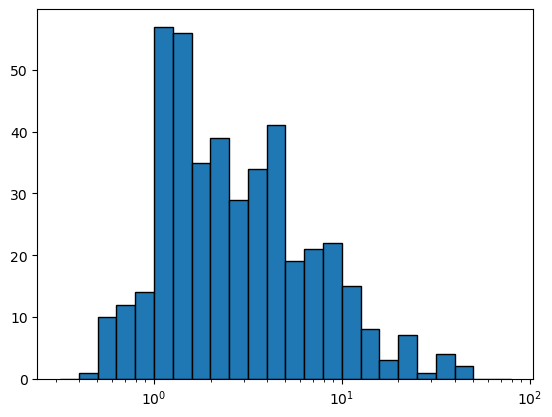

In [74]:
import matplotlib.pyplot as plt
initial_price_factor = [first_market_price[i]/latest_market_price[i] for i in range(len(latest_market_price))]
bins = 10**(.1*np.arange(-5,20))
plt.hist(initial_price_factor, bins=bins, edgecolor='black')
plt.xscale("log")
# seems that initial market prices are often several times higher than the price it settles at

In [78]:
sum([initial_price_factor[i] > 2 for i in range(len(initial_price_factor))]) / len([initial_price_factor[i] > 2 for i in range(len(initial_price_factor))])
# 54% of the initial prices are more than double the latest price in the dataset

0.541860465116279

In [11]:
# tells us whether the product is the same as the previous line product
# match_prev_product = [of_cleaned['Product'][i] == of_cleaned['Product'][i+1] for i in range(len(of_cleaned['Product'])-1)]
# match_prev_foil = [of_cleaned['Foil'][i] == of_cleaned['Foil'][i+1] for i in range(len(of_cleaned['Foil'])-1)]
# prev_market_price = of_cleaned['Market Price'][:-1]
# match_prev_product and match_prev_foil

In [12]:
# prev_market_price

In [13]:
# of_cleaned = of_cleaned[1:]
# of_cleaned = of_cleaned.reset_index(drop=True)
# of_cleaned['Previous Market Price'] = prev_market_price
# of_cleaned

In [113]:
def past_prices(num_historical_prices, df):
    dataset = copy.deepcopy(df)
    for n in range(num_historical_prices):
        match_prev_product = [dataset['Product'][i] == dataset['Product'][i+1] for i in range(len(dataset['Product'])-1)]
        match_prev_foil = [dataset['Foil'][i] == dataset['Foil'][i+1] for i in range(len(dataset['Foil'])-1)]
        # base case, take the prev market price from the previous row
        if n == 0:
            prev_market_price = dataset['Market Price'][:-1]
        # otherwise take the latest next market price from the next row
        else:
            prev_market_price = dataset[f'Previous Market Price_{n}'][:-1]
            
        dataset = dataset[1:]
        dataset = dataset.reset_index(drop=True)
        dataset[f'Previous Market Price_{n+1}'] = prev_market_price
        prev_match = [match_prev_product[i] and match_prev_foil[i] for i in range(len(match_prev_product))]
        dataset = dataset[prev_match]
        dataset = dataset.reset_index(drop=True)
    return dataset
        
        

In [103]:
def future_prices(num_historical_prices, df):
    dataset = copy.deepcopy(df)
    for n in range(num_historical_prices):
        match_next_product = [dataset['Product'][i] == dataset['Product'][i+1] for i in range(len(dataset['Product'])-1)]
        match_next_foil = [dataset['Foil'][i] == dataset['Foil'][i+1] for i in range(len(dataset['Foil'])-1)]
        # base case, take the next market price from the next row
        if n == 0:
            next_market_price = dataset['Market Price'][1:]
        # otherwise take the latest next market price from the next row
        else:
            next_market_price = dataset[f'Next Market Price_{n}'][1:]
                    
        next_market_price = next_market_price.reset_index(drop=True)
        dataset = dataset[:-1]
        dataset = dataset.reset_index(drop=True)
        dataset[f'Next Market Price_{n+1}'] = next_market_price
        next_match = [match_next_product[i] and match_next_foil[i] for i in range(len(match_next_product))]
        dataset = dataset[next_match]
        dataset = dataset.reset_index(drop=True)
    return dataset

In [102]:
[match_next_product[i] and match_next_foil[i] for i in range(len(match_next_product))]

False

In [16]:
# prev_match = match_prev_product and match_prev_foil

In [17]:
# of_cleaned = of_cleaned[prev_match]
# of_cleaned = of_cleaned.reset_index(drop=True)
# of_cleaned

In [114]:
past_prices(2, of_cleaned)
# looks pretty good

,Product,Foil,Date Range,Market Price,Previous Market Price_1,Previous Market Price_2
0,Absol ex - 135/197,Holofoil,8/5 to 8/7,4.74,4.74,4.87
1,Absol ex - 135/197,Holofoil,8/8 to 8/10,2.04,4.74,4.74
2,Absol ex - 135/197,Holofoil,8/11 to 8/13,0.80,2.04,4.74
3,Absol ex - 135/197,Holofoil,8/14 to 8/16,0.86,0.80,2.04
4,Absol ex - 135/197,Holofoil,8/17 to 8/19,0.81,0.86,0.80
...,...,...,...,...,...,...
9418,Zigzagoon,Reverse Holofoil,10/1 to 10/3,0.06,0.06,0.07
9419,Zigzagoon,Reverse Holofoil,10/4 to 10/6,0.06,0.06,0.06
9420,Zigzagoon,Reverse Holofoil,10/7 to 10/9,0.06,0.06,0.06
9421,Zigzagoon,Reverse Holofoil,10/10 to 10/12,0.06,0.06,0.06


In [105]:
future_prices(2, of_cleaned)

,Product,Foil,Date Range,Market Price,Next Market Price_1,Next Market Price_2
0,Absol ex - 135/197,Holofoil,7/30 to 8/1,4.87,4.74,4.74
1,Absol ex - 135/197,Holofoil,8/2 to 8/4,4.74,4.74,2.04
2,Absol ex - 135/197,Holofoil,8/5 to 8/7,4.74,2.04,0.80
3,Absol ex - 135/197,Holofoil,8/8 to 8/10,2.04,0.80,0.86
4,Absol ex - 135/197,Holofoil,8/11 to 8/13,0.80,0.86,0.81
...,...,...,...,...,...,...
9418,Zigzagoon,Reverse Holofoil,9/25 to 9/27,0.07,0.06,0.06
9419,Zigzagoon,Reverse Holofoil,9/28 to 9/30,0.06,0.06,0.06
9420,Zigzagoon,Reverse Holofoil,10/1 to 10/3,0.06,0.06,0.06
9421,Zigzagoon,Reverse Holofoil,10/4 to 10/6,0.06,0.06,0.06


In [115]:
# gets the next month of market prices
of_future_prices = future_prices(10, of_cleaned)
# obtains the last 15 days worth of prices
of_past_future_prices = past_prices(5, of_future_prices)
of_past_future_prices

,Product,Foil,Date Range,Market Price,Next Market Price_1,Next Market Price_2,Next Market Price_3,Next Market Price_4,Next Market Price_5,Next Market Price_6,Next Market Price_7,Next Market Price_8,Next Market Price_9,Next Market Price_10,Previous Market Price_1,Previous Market Price_2,Previous Market Price_3,Previous Market Price_4,Previous Market Price_5
0,Absol ex - 135/197,Holofoil,8/14 to 8/16,0.86,0.81,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.80,2.04,4.74,4.74,4.87
1,Absol ex - 135/197,Holofoil,8/17 to 8/19,0.81,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.86,0.80,2.04,4.74,4.74
2,Absol ex - 135/197,Holofoil,8/20 to 8/22,0.81,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,0.81,0.86,0.80,2.04,4.74
3,Absol ex - 135/197,Holofoil,8/23 to 8/25,0.92,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,0.81,0.81,0.86,0.80,2.04
4,Absol ex - 135/197,Holofoil,8/26 to 8/28,0.93,1.01,0.94,1.00,1.04,1.03,1.16,0.96,0.96,1.08,1.02,0.92,0.81,0.81,0.86,0.80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3835,Zigzagoon,Reverse Holofoil,9/1 to 9/3,0.10,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.08,0.07,0.07,0.07,0.07
3836,Zigzagoon,Reverse Holofoil,9/4 to 9/6,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.10,0.08,0.07,0.07,0.07
3837,Zigzagoon,Reverse Holofoil,9/7 to 9/9,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.11,0.10,0.08,0.07,0.07
3838,Zigzagoon,Reverse Holofoil,9/10 to 9/12,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.06,0.06,0.10,0.11,0.10,0.08,0.07


# Data Split

In [116]:
of_past_future_prices['Date Range'].unique()

array(['8/14 to 8/16', '8/17 to 8/19', '8/20 to 8/22', '8/23 to 8/25',
       '8/26 to 8/28', '8/29 to 8/31', '9/1 to 9/3', '9/4 to 9/6',
       '9/7 to 9/9', '9/10 to 9/12', '9/13 to 9/15', '8/2 to 8/4',
       '8/5 to 8/7', '8/8 to 8/10', '8/11 to 8/13'], dtype=object)

In [118]:
# test set will contain everything from September 25th on
test = of_past_future_prices.loc[of_cleaned['Date Range'].isin(['9/1 to 9/3', '9/4 to 9/6',
       '9/7 to 9/9', '9/10 to 9/12', '9/13 to 9/15'])]
train = of_past_future_prices.loc[of_cleaned['Date Range'].isin([ '8/2 to 8/4',
       '8/5 to 8/7', '8/8 to 8/10', '8/11 to 8/13', 
       '8/14 to 8/16', '8/17 to 8/19', '8/20 to 8/22', '8/23 to 8/25',
       '8/26 to 8/28', '8/29 to 8/31'])]
test

,Product,Foil,Date Range,Market Price,Next Market Price_1,Next Market Price_2,Next Market Price_3,Next Market Price_4,Next Market Price_5,Next Market Price_6,Next Market Price_7,Next Market Price_8,Next Market Price_9,Next Market Price_10,Previous Market Price_1,Previous Market Price_2,Previous Market Price_3,Previous Market Price_4,Previous Market Price_5
11,Absol ex - 214/197,Holofoil,8/20 to 8/22,1.82,1.80,1.50,1.58,1.59,1.43,1.59,1.52,1.47,1.49,1.39,1.81,1.92,1.65,3.37,6.12
12,Absol ex - 214/197,Holofoil,8/23 to 8/25,1.80,1.50,1.58,1.59,1.43,1.59,1.52,1.47,1.49,1.39,1.44,1.82,1.81,1.92,1.65,3.37
13,Absol ex - 214/197,Holofoil,8/26 to 8/28,1.50,1.58,1.59,1.43,1.59,1.52,1.47,1.49,1.39,1.44,1.52,1.80,1.82,1.81,1.92,1.65
14,Absol ex - 214/197,Holofoil,8/29 to 8/31,1.58,1.59,1.43,1.59,1.52,1.47,1.49,1.39,1.44,1.52,1.73,1.50,1.80,1.82,1.81,1.92
15,Absol ex - 214/197,Holofoil,9/1 to 9/3,1.59,1.43,1.59,1.52,1.47,1.49,1.39,1.44,1.52,1.73,1.68,1.58,1.50,1.80,1.82,1.81
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3833,Zigzagoon,Reverse Holofoil,8/26 to 8/28,0.07,0.08,0.10,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.07,0.07,0.07,0.08,0.07
3834,Zigzagoon,Reverse Holofoil,8/29 to 8/31,0.08,0.10,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.07,0.07,0.07,0.07,0.08
3835,Zigzagoon,Reverse Holofoil,9/1 to 9/3,0.10,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.08,0.07,0.07,0.07,0.07
3836,Zigzagoon,Reverse Holofoil,9/4 to 9/6,0.11,0.10,0.09,0.08,0.07,0.06,0.07,0.07,0.06,0.06,0.06,0.10,0.08,0.07,0.07,0.07


In [109]:
train

,Product,Foil,Date Range,Market Price,Previous Market Price
0,Absol ex - 135/197,Holofoil,8/2 to 8/4,4.74,4.87
1,Absol ex - 135/197,Holofoil,8/5 to 8/7,4.74,4.74
2,Absol ex - 135/197,Holofoil,8/8 to 8/10,2.04,4.74
3,Absol ex - 135/197,Holofoil,8/11 to 8/13,0.80,2.04
4,Absol ex - 135/197,Holofoil,8/14 to 8/16,0.86,0.80
...,...,...,...,...,...
9885,Zigzagoon,Reverse Holofoil,9/10 to 9/12,0.09,0.10
9886,Zigzagoon,Reverse Holofoil,9/13 to 9/15,0.08,0.09
9887,Zigzagoon,Reverse Holofoil,9/16 to 9/18,0.07,0.08
9888,Zigzagoon,Reverse Holofoil,9/19 to 9/21,0.06,0.07


In [107]:
of_cleaned.iloc[5884]

Product                  Obsidian Flames Build &amp; Battle Box Display
Foil                                                             Normal
Date Range                                                 9/22 to 9/24
Market Price                                                     121.98
Previous Market Price                                             14.48
Name: 5884, dtype: object

In [124]:
# removed 'Product' from X_test and X_train since some of the products between train and test don't match
X_test = test[[ 'Foil', 'Previous Market Price_1', 'Previous Market Price_2', 'Previous Market Price_3',
              'Previous Market Price_4', 'Previous Market Price_5', 'Market Price']]
y_test = test['Next Market Price_10'].astype(float)
X_train = train[[ 'Foil', 'Previous Market Price_1', 'Previous Market Price_2', 'Previous Market Price_3',
              'Previous Market Price_4', 'Previous Market Price_5', 'Market Price']]
y_train = train['Next Market Price_10'].astype(float)

In [126]:
X_test = pd.get_dummies(X_test, columns = ['Foil'])
X_train = pd.get_dummies(X_train, columns = ['Foil'])

# Linear Regression

In [127]:
classifier = LinearRegression()
classifier.fit(X_train, y_train)

LinearRegression()

In [128]:
coefficients = pd.DataFrame(zip(X_train.columns, classifier.coef_))
coefficients

,0,1
0,Previous Market Price_1,-0.572172
1,Previous Market Price_2,0.270944
2,Previous Market Price_3,-0.032726
3,Previous Market Price_4,0.005570
4,Previous Market Price_5,0.078941
5,Market Price,1.195024
6,Foil_Holofoil,-0.102611
7,Foil_Normal,-0.123918
8,Foil_Reverse Holofoil,0.226529


In [129]:
y_pred = classifier.predict(X_test)

In [131]:
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
#     mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)

    print('explained_variance: ', round(explained_variance,4))    
#     print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [132]:
regression_results(y_test, y_pred)
# over 98% of variance explained which makes sense given that it has access to previous values

explained_variance:  0.9883
r2:  0.9883
MAE:  0.57
MSE:  7.1737
RMSE:  2.6784
